In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

#### Statistics on the data from the book

In [109]:
insulin_sensitiv = np.array([250, 220, 145, 115, 230, 200, 330, 400, 370, 260, 270, 530, 375])
C2022_fatacids = np.array([17.9, 18.3, 18.3, 18.4, 18.4, 20.2, 20.3, 21.8, 21.9, 22.1, 23.1, 24.2, 24.4])

In [110]:
print(np.mean(insulin_sensitiv))
print(np.mean(C2022_fatacids))

284.2307692307692
20.71538461538461


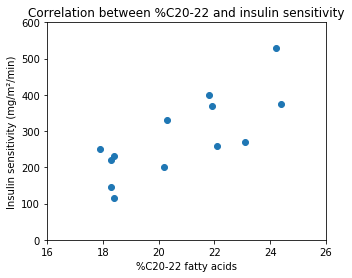

In [111]:
plt.figure(figsize=(5,4))
plt.scatter(C2022_fatacids, insulin_sensitiv)
plt.title('Correlation between %C20-22 and insulin sensitivity')
plt.xlabel('%C20-22 fatty acids')
plt.ylabel('Insulin sensitivity (mg/m²/min)')
plt.axis((16, 26, 0, 600));

In [112]:
# covariance is the mean of the products (xi-X)(yi-Y)
np.cov(C2022_fatacids, insulin_sensitiv)

array([[5.55474359e+00, 2.06679487e+02],
       [2.06679487e+02, 1.29701923e+04]])

In [113]:
np.corrcoef(C2022_fatacids, insulin_sensitiv)

array([[1.        , 0.77000254],
       [0.77000254, 1.        ]])

In [114]:
r, P_val = stats.pearsonr(C2022_fatacids, insulin_sensitiv)
print(f'Correlation coefficient r = {r:3.2f}')
print(f'P value (two-tailed) = {P_val:5.4f}')

Correlation coefficient r = 0.77
P value (two-tailed) = 0.0021


The direction and magnitude of the linear correlation can be quantified with _r_. If _r_ = 0, the two variables do not vary together at all. If _r_ > 0, the two variables tend to increase **or decrease** together.

H0 is that there is no correlation between variables. If the H0 were true, what is the chance that 13 randomly picked subjects would have an r greater than 0.77 or less than -0.77?

In [115]:
r_sq = r**2
print(f"r² = {r_sq:5.4f}")

r² = 0.5929


r² is the fraction of the variance shared between the two variables. Here, 59% of the variability in insulin tolerance is associated with variability in lipid content. Knowing the lipid content lets you explain 59% of the variance in the insulin sensitivity. That leaves 41% of the variance to be explained by other factors or by measurement error. We can also say that 59% of the variability in lipid content is associated with variability in insulin tolerance.

#### Computation of the CI

There is no way to determine the CI easily with scipy, therefore let's do some bootstraping analysis.

In [29]:
bs_r = [stats.pearsonr(
    np.random.choice(C2022_fatacids, len(C2022_fatacids)),
    np.random.choice(insulin_sensitiv, len(insulin_sensitiv))) for _ in range(10000)]

In [30]:
np.percentile(bs_r, [2.5, 97.5])

array([-0.47683403,  0.94926134])

In [31]:
#let's try while permuting only the first array
bs_r = [stats.pearsonr(
    np.random.choice(C2022_fatacids, len(C2022_fatacids)), insulin_sensitiv) 
        for _ in range(10000)]

In [32]:
np.percentile(bs_r, [2.5, 97.5])

array([-0.460223  ,  0.95081754])

The computation of a confidence interval on the population value of Pearson's correlation _r_ is complicated by the fact that the **sampling distribution of r is not normally distributed**. The solution lies with [Fisher's z' transformation] (https://en.wikipedia.org/wiki/Fisher%5ftransformation) described in the section on the sampling distribution of Pearson's r:
1. Convert r to z' (Fisher's Z-score)
2. Compute a confidence interval in terms of z'
3. Convert the confidence interval back to r.

In [33]:
r_z = np.arctanh(r)

The corresponding standard deviation is $se = \dfrac{1}{\sqrt{N-3}}$

In [35]:
se = 1/np.sqrt(len(C2022_fatacids)-3)

CI under the transformation can be calculated as $r_z \pm z_{\alpha/2}\times se$ where $z_{\alpha/2}$ is can be calculated using 

In [50]:
alpha = 0.05
z = stats.norm.ppf(1-alpha/2) # here note that the distribution is not symetrical
ci = np.tanh((r_z-z*se, r_z+z*se))
print(f"The confidence interval of the Pearson's coefficient r = {ci}")

The confidence interval of the Pearson's coefficient r = [0.38041003 0.9274906 ]


#### Let's do some bootstap analysis using this test statistic

In [125]:
# we keep the pairs but choose various indexes
size=10000
bs_r = np.empty(shape=(size,1))
inds = np.arange(len(C2022_fatacids))

for _ in range(size):
    bs_inds = np.random.choice(inds, len(inds))
    bs_r[_] = stats.pearsonr(C2022_fatacids[bs_inds], insulin_sensitiv[bs_inds])[0]

In [126]:
np.percentile(bs_r, [2.5, 97.5])

array([0.53278706, 0.91281809])

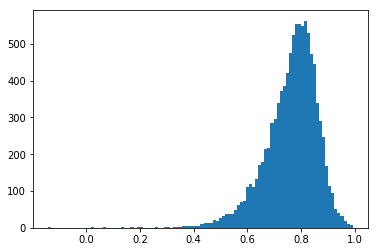

In [127]:
plt.hist(bs_r, bins=100);

#### Compute a P value using boostrap analysis

In [137]:
# we permute the data from one dataset in line with H0
# test statistic is heritability (cov/s²)

size=10000
bs_r = np.empty(shape=(size,1))
inds = np.arange(len(C2022_fatacids))

for _ in range(size):
    bs_inds = np.random.choice(inds, len(inds))
    bs_X = np.random.permutation(C2022_fatacids)
    bs_r[_] = np.cov(bs_X[bs_inds], insulin_sensitiv[bs_inds])[0,1] / np.cov(
        bs_X[bs_inds], insulin_sensitiv[bs_inds])[0,0]

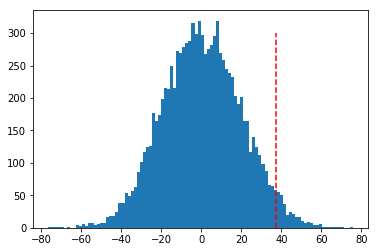

In [145]:
herit = np.cov(C2022_fatacids, insulin_sensitiv)[0,1] / np.cov(
    C2022_fatacids, insulin_sensitiv)[0,0]
plt.hist(bs_r, bins=100)
plt.vlines(herit, ymin=0, ymax=300, colors='red', linestyle='--');

In [146]:
P_value = np.sum(bs_r >= herit) / size
print(f'P value (two-tailed) using permutation = {P_value:5.4f}')

P value (two-tailed) using permutation = 0.0317


This is far higher than the P value computed with stats, might be good to find another test stat...